<a href="https://colab.research.google.com/github/valmyr/ConversaoEletromecanica/blob/main/ex3_convers%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d
import scipy as sci
from scipy.misc import derivative

In [ ]:
# Dados do problema
Wm =   2*1e-2
Wg = 2.5*1e-2
D  = 3.0*1e-2
d  = 1.0*1e-2
g  = 0.2*1e-2
u0 = 4*np.pi*1e-7
Hc = -50*1e+3
Br = 1.2
ur = Br/(-Hc)
Nf =1

In [ ]:
numero_de_pontos = 260
Am  = Wm*D #Area do imã
Aa  = lambda x:(Wg-x)*D # Área do gap em função da posição

In [ ]:
B = np.array([1.20,  1.19,  1.15,  1.13,  1.11,  1.08, 1.05,   1.02,  0.96,  0.85,  0.80,  0.75,  0.70,  0.60,   0.1,   0.0])
H = np.array([0.00, -5.00,-10.00,-15.00,-20.00,-25.00,-30.00,-35.00,-40.00,-45.00,-46.00,-47.00,-48.00,-49.00,-50.00,-50.75])*1e+3

Text(0, 0.5, 'Densidade de Fluxo(T)')

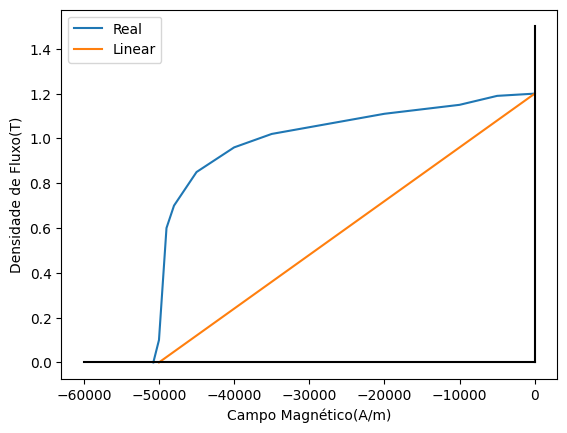

In [ ]:
# Plote B por H caso linear e real
interpolacao_H_por_B_real   = interp1d(B[::-1],H[::-1],kind='cubic') #Característica real do núcleo
interpolacao_H_por_B_linear =  lambda Bm: (Bm/ur) + Hc #Aproximação da forma linear
plt.plot(interpolacao_H_por_B_real(B),B)
plt.plot(interpolacao_H_por_B_linear(B),B)
plt.plot([-60000,0], [0,0], color = "black")
plt.plot([0,0], [0,1.5], color = "black")
plt.legend(["Real", "Linear"])
plt.xlabel("Campo Magnético(A/m)")
plt.ylabel("Densidade de Fluxo(T)")

In [ ]:
# Função para calculo da cooenergia
def calc_forca_e_coenergia(interpolacao_H_por_Baa,Nf):
  posicao  = np.linspace(0,Wg,numero_de_pontos) # Definindo variação da posição
  Bm = np.linspace(0,1.2,numero_de_pontos) # Definindo variação do fluxo do imã
  If = np.zeros(numero_de_pontos)
  fluxo_concat = np.zeros(numero_de_pontos)
  Co_energia = np.zeros(numero_de_pontos)
  Co_energia_Nf_1500 = np.zeros(numero_de_pontos)


  # limite_superior_da_integral_I0 =

  """Para encontrar o a corrente fictícia, foi aplicado a lei de ámpere (N.I = Hm.d + Hg.2g)
     colocando Hm e Hg em função de B """
  for x in range(len(posicao)-1):
    for b in range(len(Bm)):
      If[b] = ((interpolacao_H_por_Baa(Bm[b])*d) + ((2*g*Bm[b]*Am)/(Aa(posicao[x])*u0)))/Nf
      fluxo_concat[b] =  Nf*Bm[b]*Am
    if(f'{posicao[x]:.4f}' == str(Wg/2)): # Selecinar a Bg para d = Wg/2
      # Copiar os valores dos vetores da posição para condição dada
      Bg_Wg_por_2 = np.copy(Bm*(Am/Aa(posicao[x])))
      If_Wg_por_2 = np.copy(If)
    # Interpolação de Fluxo conc., Bm, If
    interpolacao_Fluxo_concat_por_If = CubicSpline(If,fluxo_concat)
    interpolacao_Bm_por_If = interp1d(If,Bm,kind='cubic')
    interpolacao_If_por_Bm = interp1d(Bm,If,kind='cubic')
    I0 = interpolacao_If_por_Bm(0) # Limite inferior, onde o fluxo concatena é 0
    # Intevalo superior de INTEGRAÇÃO????
    Iint = np.linspace(I0, 0,numero_de_pontos)
    Fluxo_concat_Interpolado = interpolacao_Fluxo_concat_por_If(Iint)
    Co_energia[x] = sci.integrate.trapezoid(Fluxo_concat_Interpolado,Iint) # Calcular a cooenergia pela integral
    Bop = 1.07
    Hop = -31.14*1e+3
    Iop =   (Hop*d+(2*g*Bop*Am)/(Aa(Wg/2)*u0))/Nf
    # print(f'As correntes: {I0}, {Iop}')

    Iint_Nf_1500 =np.linspace(I0,Iop,numero_de_pontos)
    Fluxo_concat_Interpolado_Nf_1500 = interpolacao_Fluxo_concat_por_If(Iint_Nf_1500)
    Co_energia_Nf_1500[x] = sci.integrate.trapezoid(Fluxo_concat_Interpolado_Nf_1500,Iint_Nf_1500)

  """ Quando Nf for 1500 espiras, o cálculo da força é de 0 a Wg/2. E também é calculado a densidade de fluxo do ar"""
  if(Nf == 1500):
    interpolacao_Co_energia_por_Posicao_Nf_1500 = CubicSpline(posicao[:len(posicao)-1],Co_energia_Nf_1500[:len(posicao)-1])
    F_Nf_1500 = derivative(interpolacao_Co_energia_por_Posicao_Nf_1500, posicao[:len(posicao)-1],dx=1/numero_de_pontos) # Derivando o vetor de cooenergia
    return Bg_Wg_por_2, If_Wg_por_2, F_Nf_1500,(posicao[:len(posicao)-1])
  """Retorno para quando Nf for arbitrária"""
  interpolacao_Co_energia_por_Posicao = CubicSpline(posicao[:len(posicao)-1],Co_energia[:len(posicao)-1])
  F = derivative(interpolacao_Co_energia_por_Posicao,posicao[0:len(posicao)-1],dx=1/numero_de_pontos) # Derivando o vetor de cooenergia
  return F,Co_energia[:len(Co_energia)-1],(posicao[:len(posicao)-1])

<ipython-input-82-4473be8b2853>:48: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  F = derivative(interpolacao_Co_energia_por_Posicao,posicao[0:len(posicao)-1],dx=1/numero_de_pontos) # Derivando o vetor de cooenergia


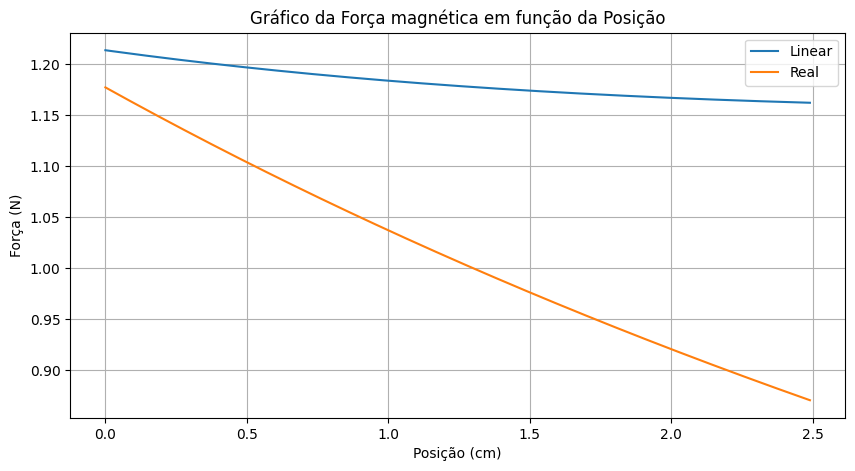

In [ ]:
# Obtém os valores das forças real e linear para elaborar o gráfico
Forca_real, Co_energia_real,x = calc_forca_e_coenergia(interpolacao_H_por_B_real,Nf)
Forca_linear, Co_energia_linear,x = calc_forca_e_coenergia(interpolacao_H_por_B_linear,Nf)
# Fazendo o plot da Força magnética em função da Posição, Gráfico do Item 1 e 2
plt.figure(figsize = [10,5])
plt.plot(x[::-1]*100,-Forca_real)
plt.plot(x[::-1]*100,-Forca_linear)
plt.legend(["Linear", "Real"])
plt.xlabel("Posição (cm)")
plt.ylabel("Força (N)")
plt.title("Gráfico da Força magnética em função da Posição")
plt.grid(True)


<ipython-input-82-4473be8b2853>:44: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  F_Nf_1500 = derivative(interpolacao_Co_energia_por_Posicao_Nf_1500, posicao[:len(posicao)-1],dx=1/numero_de_pontos) # Derivando o vetor de cooenergia


Text(0.5, 1.0, 'Gráfico da densidade de fluxo no entreferro em função da corrente na bobina')

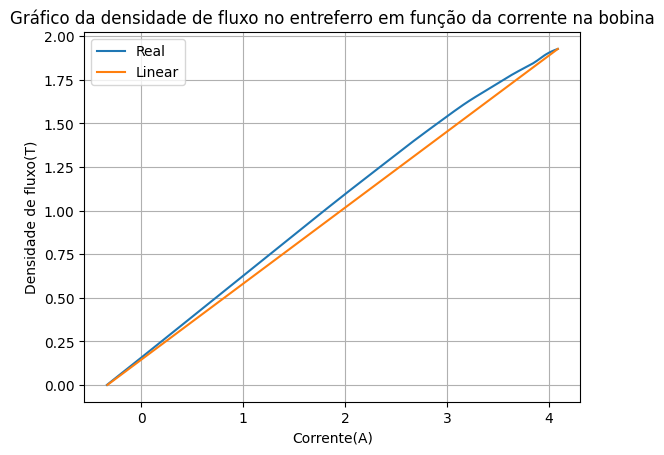

In [ ]:
# Item 3 e 4: Obtém a densidade de fluxo do ar para metade do deslocamento
Bg_Wg_por_2_real, If_Wg_por_2_real, Forca_Wg_2_real, x_Wg_2_real = calc_forca_e_coenergia(interpolacao_H_por_B_real,1500)
Bg_Wg_por_2_linear, If_Wg_por_2_linear , Forca_Wg_2_linear, x_Wg_2_linear = calc_forca_e_coenergia(interpolacao_H_por_B_linear,1500)


plt.plot(If_Wg_por_2_real,Bg_Wg_por_2_real)
plt.plot(If_Wg_por_2_linear,Bg_Wg_por_2_linear)
plt.legend(["Real", "Linear"])
plt.ylabel("Densidade de fluxo(T)")
plt.xlabel("Corrente(A)")
plt.grid(True)
plt.title("Gráfico da densidade de fluxo no entreferro em função da corrente na bobina")

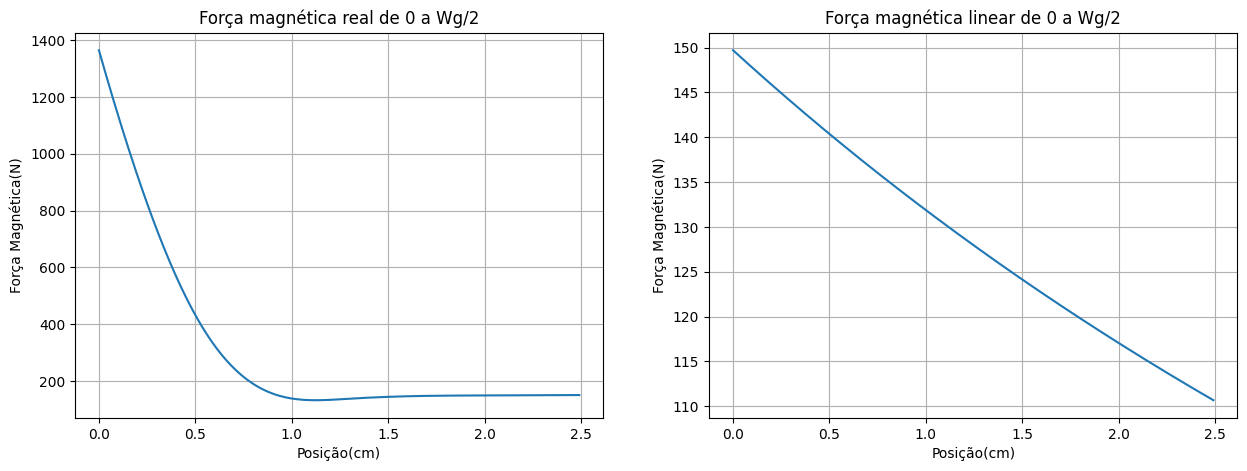

In [ ]:
# Item 4: Plot da força magnética em função a posição para metade do deslocamento Wg/2
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.plot(x_Wg_2_real*100, abs(Forca_Wg_2_real))
plt.ylabel("Força Magnética(N)")
plt.xlabel("Posição(cm)")
plt.title("Força magnética real de 0 a Wg/2")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_Wg_2_linear[::-1]*100, abs(Forca_Wg_2_linear))
plt.ylabel("Força Magnética(N)")
plt.xlabel("Posição(cm)")
plt.title("Força magnética linear de 0 a Wg/2")
plt.grid(True)